In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import re

import random

In [3]:
from utils import *

In [4]:
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Management

### Alphabets Setup

In [5]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [6]:
# kannada Unicode dec Range

kannada_alphabets = [chr(alpha) for alpha in range(3202, 3311)]
kannada_alphabet_size = len(kannada_alphabets)

kannada_alpha2index = {pad_char: 0}
for index, alpha in enumerate(kannada_alphabets):
    kannada_alpha2index[alpha] = index+1

print(kannada_alpha2index)

{'-PAD-': 0, 'ಂ': 1, 'ಃ': 2, '\u0c84': 3, 'ಅ': 4, 'ಆ': 5, 'ಇ': 6, 'ಈ': 7, 'ಉ': 8, 'ಊ': 9, 'ಋ': 10, 'ಌ': 11, '\u0c8d': 12, 'ಎ': 13, 'ಏ': 14, 'ಐ': 15, '\u0c91': 16, 'ಒ': 17, 'ಓ': 18, 'ಔ': 19, 'ಕ': 20, 'ಖ': 21, 'ಗ': 22, 'ಘ': 23, 'ಙ': 24, 'ಚ': 25, 'ಛ': 26, 'ಜ': 27, 'ಝ': 28, 'ಞ': 29, 'ಟ': 30, 'ಠ': 31, 'ಡ': 32, 'ಢ': 33, 'ಣ': 34, 'ತ': 35, 'ಥ': 36, 'ದ': 37, 'ಧ': 38, 'ನ': 39, '\u0ca9': 40, 'ಪ': 41, 'ಫ': 42, 'ಬ': 43, 'ಭ': 44, 'ಮ': 45, 'ಯ': 46, 'ರ': 47, 'ಱ': 48, 'ಲ': 49, 'ಳ': 50, '\u0cb4': 51, 'ವ': 52, 'ಶ': 53, 'ಷ': 54, 'ಸ': 55, 'ಹ': 56, '\u0cba': 57, '\u0cbb': 58, '಼': 59, 'ಽ': 60, 'ಾ': 61, 'ಿ': 62, 'ೀ': 63, 'ು': 64, 'ೂ': 65, 'ೃ': 66, 'ೄ': 67, '\u0cc5': 68, 'ೆ': 69, 'ೇ': 70, 'ೈ': 71, '\u0cc9': 72, 'ೊ': 73, 'ೋ': 74, 'ೌ': 75, '್': 76, '\u0cce': 77, '\u0ccf': 78, '\u0cd0': 79, '\u0cd1': 80, '\u0cd2': 81, '\u0cd3': 82, '\u0cd4': 83, 'ೕ': 84, 'ೖ': 85, '\u0cd7': 86, '\u0cd8': 87, '\u0cd9': 88, '\u0cda': 89, '\u0cdb': 90, '\u0cdc': 91, '\u0cdd': 92, 'ೞ': 93, '\u0cdf': 94, 'ೠ': 95, 'ೡ': 96, 'ೢ': 97, 'ೣ'

### Helper functions for data pre-processing

In [7]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

### Dataset Loading

In [8]:
MAX_OUTPUT_CHARS = 30
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.kannada_words = self.readXmlDataset(filename, cleankannadaVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.kannada_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            if len(wordlist1) != len(wordlist2):
#                 print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue
            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        kannada_batch = self.get_batch_from_array(batch_size, self.kannada_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, kannada_batch


Please change the path accordingly

In [9]:
train_data = TransliterationDataLoader('Dataset/LangaugeTranslation/NEWS2012-Training-EnKa-11955.xml')
test_data = TransliterationDataLoader('Dataset/LangaugeTranslation/NEWS2012-Ref-EnKa-1000.xml')

In [10]:
# train_data.get_batch(3)

### Basic Data Visualization

In [11]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, kannada = train_data.get_random_sample()
    print(eng + ' - ' + kannada)

Train Set Size:	 17153
Test Set Size:	 1000

Sample data from train-set:
KHOMEINI - ಖೊಮೇನಿ
SOCIETY - ಸೊಸೈಟಿ
SAHEB - ಸಾಬ್
CHIP - ಚಿಪ್
PATTO - ಪತ್ತೋ
MAAL - ಮಾಲ್
AUDAEN - ಔದೀನ್
DUDLEY - ಡುಡ್ಲೆ
CROWE - ಕ್ರೋವ್
SHIBANI - ಶಿಬಾನಿ


## Network Architecture

### Encoding the words

### Encoder-Decoder with Attention 


In [12]:
MAX_OUTPUT_CHARS = 30


In [13]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(kannada_alpha2index), verbose=True)

## Training

In [14]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, kannada_batch = train_data.get_batch(batch_size)
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(kannada_batch[i], kannada_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [15]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

### Training with Attention 

In [16]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(kannada_alpha2index))

Iteration 3499 Loss 0.1099669337272644


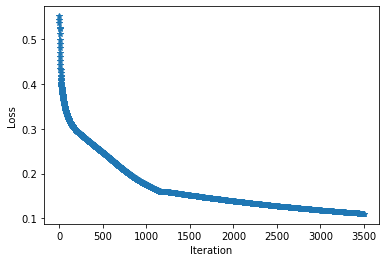

In [16]:
loss_history = train_setup(net_att, lr=0.001, n_batches=3500, batch_size = 64, display_freq=10, device = device_gpu)

## Inference

In [30]:
def infer(net, word, char_limit, device = 'cpu'):
    input = word_rep(word, eng_alpha2index, device)
    return net(input, char_limit)

In [56]:
res = dict((v,k) for k,v in kannada_alpha2index.items())

In [59]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    kannada_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        print(index)
        kannada_char = res[index]
        kannada_output += kannada_char
    print(word + ' - ' + kannada_output)
    return kannada_output

In [64]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, kannada = test_data[i]
        print(eng, kannada)
        gt = gt_rep(kannada, kannada_alpha2index, device)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            kannada_pos = indices.tolist()[0]
            print(kannada_pos)
            if kannada_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [1]:
# accuracy_attn = calc_accuracy(net_att) * 100
# print('Acurracy with attention', accuracy_attn)